In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as ss

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# set some styling defaults for matplotlib
plt.style.use("seaborn-talk")
mpl.rcParams["figure.dpi"] = 90  # change this to set apparent figure size
mpl.rcParams["figure.figsize"] = (7, 3)
mpl.rcParams["figure.frameon"] = False

# set decimal precision to 3 dec. places
%precision 3

'%.3f'

In [2]:
# %pip install pymc3 
# uncomment to install pymc3. 
# Note that this can be tricky on Windows; make sure you are in a conda environment or virtualenv!

In [3]:
import pymc3
import arviz as az

# turn off extra messages
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Example 3: Bayesian analysis
## Outcomes

* How to analyse experimental results from a Bayesian perspective
    * How to build a simple model
    * The effect of priors
    * How to apply inference via MCMC
    * How to interpret and report results   

## Goal

* analyse the result of experimental work using Bayesian principles. 
* be informed by priors
* maintain uncertainty consistently
* answer questions in terms of probabilities of hypotheses (*not* in terms of probabilities of data!).
* report and visualise those results to answer questions we  might be interested in.


## Task
We are going to model the results of **Fitts' law** experiment, a classic HCI task. Fitts' law, very briefy, is a fairly consistent relationship observed in human pointing actions, like clicking an icon with a mouse. It says that there is an approximately linear relationship between the time taken to acquire a target and the target's "index of difficulty".

The "index of difficulty" is just the logarithm of the ratio of the target size to its distance from the starting point -- it corresponds to the the log of the number of possible targets made by dividing up space into evenly spaced regions of fixed width.

The basic formula looks like:

$$MT = a + bID$$
$$MT = a + b\log_2\left(\frac{D}{W}\right)$$

$MT$ is the movement time (in seconds) and $ID$ is the index of difficulty (in bits).  $D$ and $W$ are distance and width, and $a$ and $b$ are parameters that *we don't know*. We'd expect $a$ and $b$ to be consistent for a particular pointing device/context, but to vary for different devices. For example, a high-DPI optical mouse might have a lower $b$ than a console controller joystick (i.e. can acquire more precise targets in the same time for the high-DPI mouse).

### How does this relate to traditional frequentist statistics?

<img src="linear_models.PNG">

[By Jonas Kristoffer Lindeløv: https://lindeloev.github.io/tests-as-linear/]

## Process

We are going to write down our data generating process, set priors on the parameters and then implement this in code using a probabilistic programming language. Once this is done, we will use MCMC sampling to draw samples from the prior and posterior distributions (and the prior and posterior *predictive* distributions). 

The power of a probabilistic programming language (PPL) means that the MCMC sampling step is *automatic*; we don't have to do anything to invert our model. We implement the DGP, and expose it to data.

We can then summarise and compare the results of inference. We'll explore what effect setting priors has, and how we can use the resulting distributions to answer useful questions.

## Package: `pymc3`
We are going to use `pymc3` for inference. This is the most capable PPL for Python; there are other choices like Stan (own custom language; integrates well with R) with similar capabilities. 

`pymc3` defines a range of standard probability distributions associated with random variables, and allows us to write expressions over random variables. We can then directly introduced observed data to draw *samples* from the posterior distribution. `pymc3` works by MCMC sampling, so it only ever produces sequences of definite random samples, and it is subject to the approximation problems that MCMC approaches can have.

## Setup

First, lets load some data. We assume this came from a human subjects trial [it didn't, I simulated it], where participants were asked to point at targets with variable widths and distances. Each participant repeated each acquisition several times. 

In [4]:
fitts_data = pd.read_csv("fitts_a.csv")
fitts_data.head()

,Unnamed: 0,ID,MT,participant,repetition,step
0,0,0.5,0.271905,0,0,0
1,1,0.5,0.269501,1,0,0
2,2,0.5,0.284559,2,0,0
3,3,0.5,0.392585,3,0,0
4,4,0.5,0.345104,4,0,0


Text(0, 0.5, 'Movement time (s)')

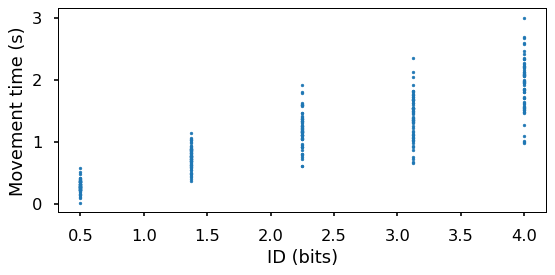

In [5]:
# plot the data
fitts_data.plot.scatter('ID', 'MT', s=5)
plt.gca().set_xlabel("ID (bits)")
plt.gca().set_ylabel("Movement time (s)")

In [6]:
from pymc3_utils import pymc3_sample, trace_hist

### Building a model

Our data generating process is rather basic, but follows directly from the formula above. Note that we introduce a *noise term* to accommodate the imprecision of any experiment like this.

So we have:
$$MT = a + b ID + \epsilon$$

We'll assume, for simplicity, that $\epsilon$ is normally distributed noise; this is a reasonable guess. So:

$$MT = a + b ID + \mathcal{N}(0, s)$$

$s$ (the noise level) is also unknown, so we'll chuck it in the pile of parameters we want to infer.


In [7]:
## generative model
def generate_mt(a, b, std, id):
    # returns seconds
    return a + b * id + np.random.normal(0, std)


In [8]:
generate_mt(0.1, 0.45, 0.1, 4.0)

1.897

We also need a log-likelihood; in this case, this is easy:

In [9]:
## generative model
def lik_mt(a, b, std, id, mt):
    # returns seconds
    return ss.norm(a + b * id, std).logpdf(mt)

In [10]:
lik_mt(0.1, 0.45, 0.1, 4.0, mt=1.7)

-0.6163534402106308

In [11]:
lik_mt(0.1, 0.45, 0.1, 4.0, mt=10.7)

-3870.6163534402094

### pymc3 model
We just need to translate this into the pymc3 primitives, and set priors for a, b, s. We'll make some very weak guesses about what a,b,s might be.

In [12]:
with pymc3.Model() as fitts_model:
    # define the model
    a = pymc3.Normal("a", 0, 1)     # N(0,1)           
    b = pymc3.Normal("b", 1)        # N(0,1)
    std_prior = pymc3.HalfNormal("sigma", 1)        # HN(0,1)
    # note: the prior here has no effect on inference
    # but it is useful for simulating without data
    ids = pymc3.Uniform("ids", 0.0, 5.0, observed=fitts_data["ID"])        # U(0,5)
    lin = a + b * ids
    # mt = N(a+b*id, sigma)
    mt = pymc3.Normal("mt", mu=lin, sigma=std_prior, observed=fitts_data["MT"])
    trace = pymc3_sample()
    trace["observed"] = {"mt":fitts_data["MT"], "id":fitts_data["ID"]}
    
fitts_result = trace

#### Summarising results

In [13]:
trace.keys()

dict_keys(['posterior', 'prior', 'posterior_predictive', 'observed'])

In [14]:
trace["posterior"]["a"]

array([0.115, 0.079, 0.068, ..., 0.135, 0.158, 0.16 ])

In [15]:
print(az.hdi(trace["posterior"]["a"]))
print(az.hdi(trace["posterior"]["b"]))
print(az.hdi(trace["posterior"]["sigma"]))

[0.037 0.166]
[0.423 0.474]
[0.276 0.32 ]


Got error No model on context stack. trying to find log_likelihood in translation.
C:\local\anaconda3\envs\pymc3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


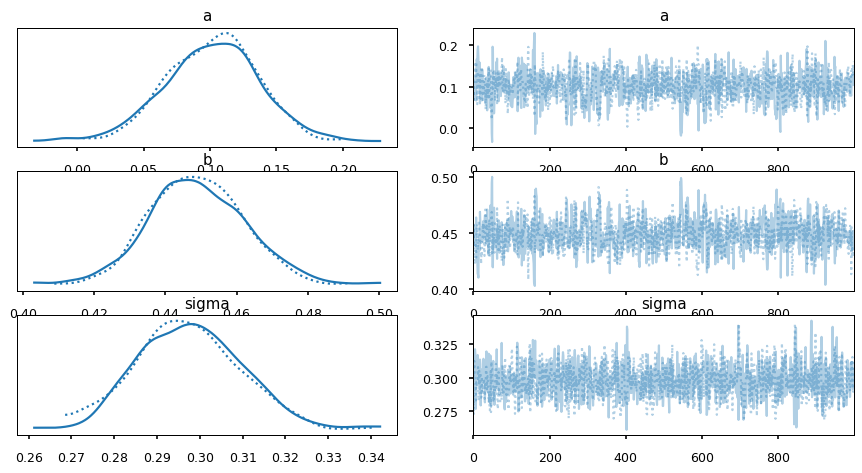

In [16]:

az.plot_trace(trace["posterior"]);

In [17]:
print(np.mean(trace["posterior"]["a"]), np.mean(trace["posterior"]["b"]))

0.10165781445743244 0.4489680791314307


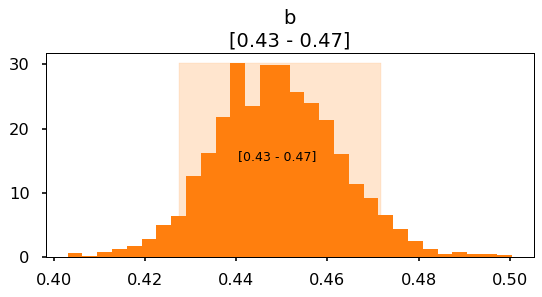

In [18]:
fig, ax = plt.subplots()
trace_hist(ax, trace["posterior"]['b'], "b")

#### Prior vs posterior

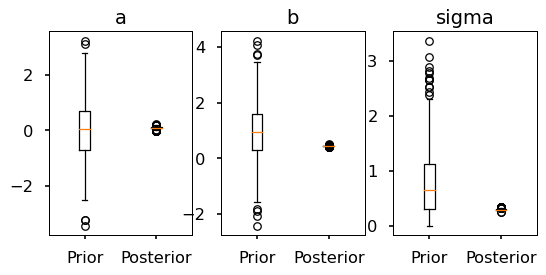

In [19]:
# compare prior and posterior
fig, ax = plt.subplots(ncols=3)
def prior_posterior(ax, var):
    ax.boxplot([trace["prior"][var], trace["posterior"][var]], labels=["Prior", "Posterior"])
    ax.set_title(var)
    
prior_posterior(ax[0], "a")
prior_posterior(ax[1], "b")
prior_posterior(ax[2], "sigma")

In [20]:
def show_model(all_trace, mode="posterior"):
    trace = all_trace[mode]
    fig = plt.figure(constrained_layout=True, figsize=(9,4))
    gs = fig.add_gridspec(3, 3)
    a_plot = fig.add_subplot(gs[0,0])
    b_plot = fig.add_subplot(gs[0,1])
    sig_plot = fig.add_subplot(gs[0,2])
    pred_plot = fig.add_subplot(gs[1:3,:])
    
    trace_hist(a_plot, trace["a"], "a")
    trace_hist(b_plot, trace["b"], "b")
    trace_hist(sig_plot, trace["sigma"], "$\sigma$")
    a_plot.set_xlim(-1, 1)
    b_plot.set_xlim(-1, 1)
    sig_plot.set_xlim(0, 1)
    x_range = np.linspace(0.5, 5, 20)
    pred_plot.set_xlim(0, 5)
    pred_plot.set_ylim(0, 3)
    pred_plot.set_xlabel("Index of difficulty")
    pred_plot.set_ylabel("Movement time")
    samples = 500
    for _a, _b in zip(trace["a"][:samples], trace["b"][:samples]):        
        pred_plot.plot(x_range, _a + _b * x_range, alpha=0.1, c='C2', lw=0.75)
    if mode=="posterior":
        pred_plot.scatter(all_trace["observed"]["id"], all_trace["observed"]["mt"], c='k', zorder=10, s=2)
        n = len(all_trace["observed"]["id"])
        fig.suptitle(f"N={n}")
    else:
        fig.suptitle("Prior")  

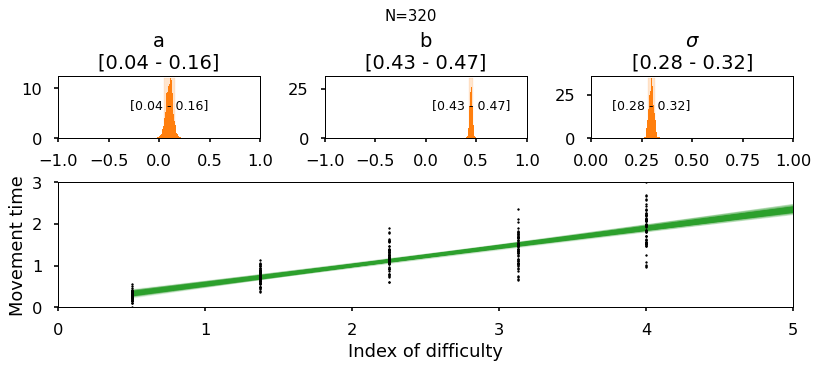

In [21]:
show_model(trace, mode='posterior')

#### Prior checks

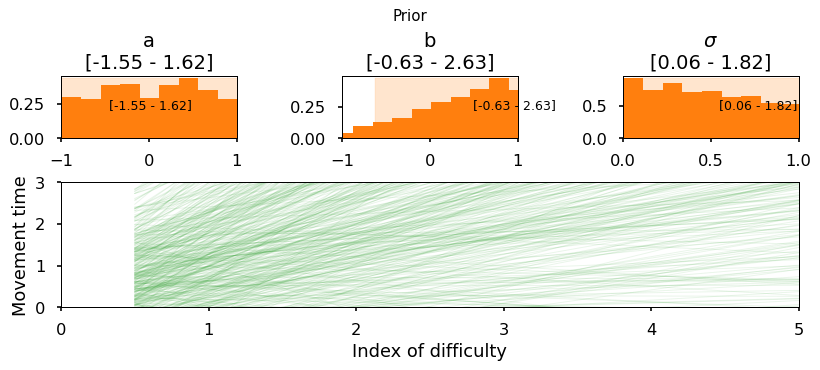

In [22]:
show_model(trace, mode='prior')

### Experimenting
Let's play around with the model; I'll wrap the model in a function to make it easy to tweak priors and subsample data:

In [23]:

def sample_model(data_id, data_mt, a_prior=1, b_prior=2, std_prior=1, a_mean_prior=0, b_mean_prior=0, b_positive=False, ns=None):        
    # choose the a subset if requested
    if ns:
        subset = np.random.randint(0, data_id.shape[0], ns)
        data_id = data_id[subset]
        data_mt = data_mt[subset]
    
    with pymc3.Model() as model:        
        a = pymc3.Normal("a", a_mean_prior, a_prior)        
        if b_positive:
            b = pymc3.HalfNormal("b", b_prior)    
        else:
            b = pymc3.Normal("b", b_mean_prior, b_prior)                
        std_prior = pymc3.HalfNormal("sigma", std_prior)        
        ids = pymc3.Uniform("ids", 0.0, 5.0, observed=data_id)        
        lin = a + b * ids        
        mt = pymc3.Normal("mt", mu=lin, sigma=std_prior, observed=data_mt)
        return pymc3_sample(observed={"mt":data_mt, "id":data_id})        
    return results


#### What if we assumed different priors?

##### Weaker

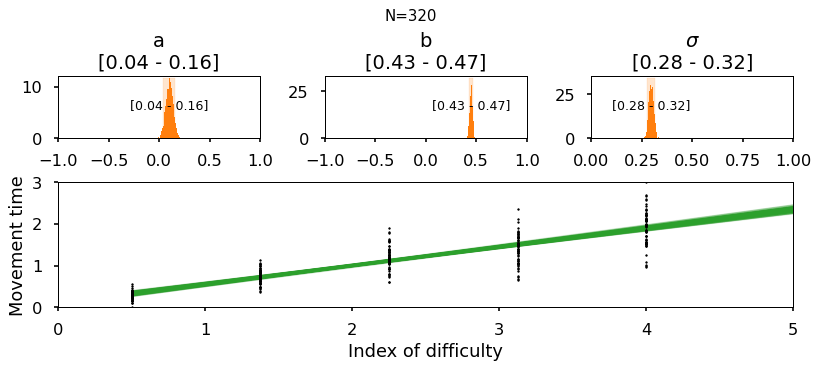

In [24]:
result_weak = sample_model(fitts_data["ID"], fitts_data["MT"], a_prior=5, b_prior=5, std_prior=5);
show_model(result_weak)

##### Stronger (more informed)

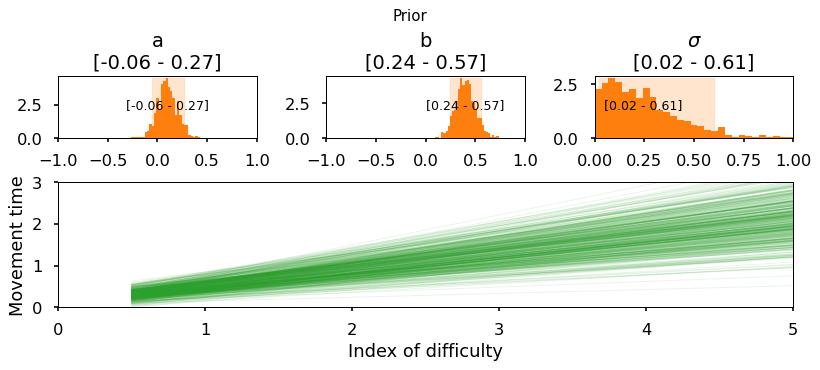

In [25]:
result_strong = sample_model(fitts_data["ID"], fitts_data["MT"], a_prior=0.1, b_prior=0.1, 
                             a_mean_prior=0.1, b_mean_prior=0.4, std_prior=0.3);
show_model(result_strong, mode='prior')

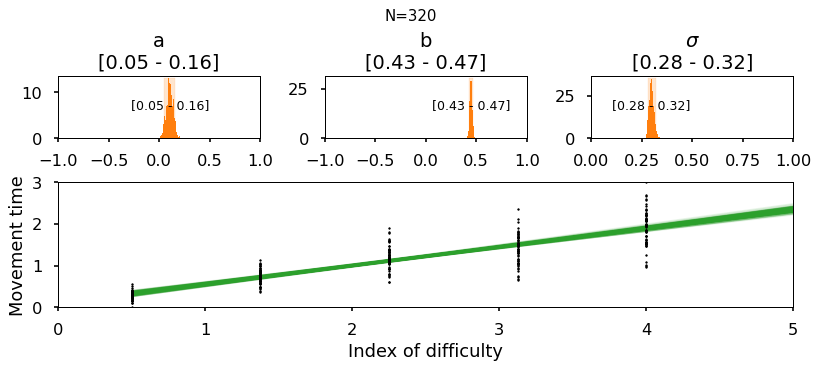

In [26]:
show_model(result_strong)

##### Stronger (badly informed)

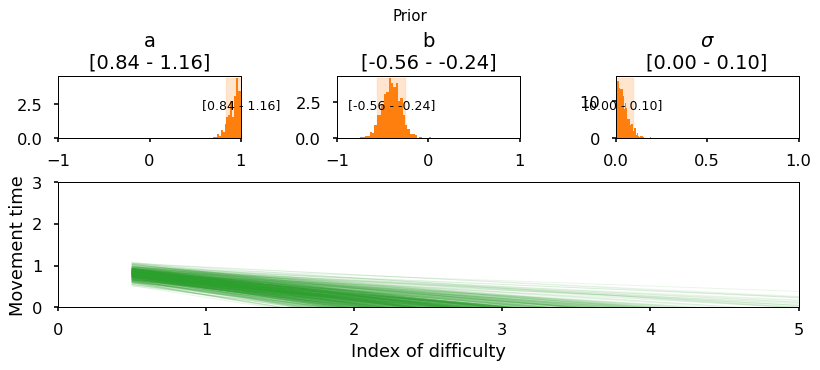

In [27]:
result_bad = sample_model(fitts_data["ID"], fitts_data["MT"], a_prior=0.1, b_prior=0.1, a_mean_prior=1.0, b_mean_prior=-0.4, std_prior=0.05);
show_model(result_bad, mode='prior')

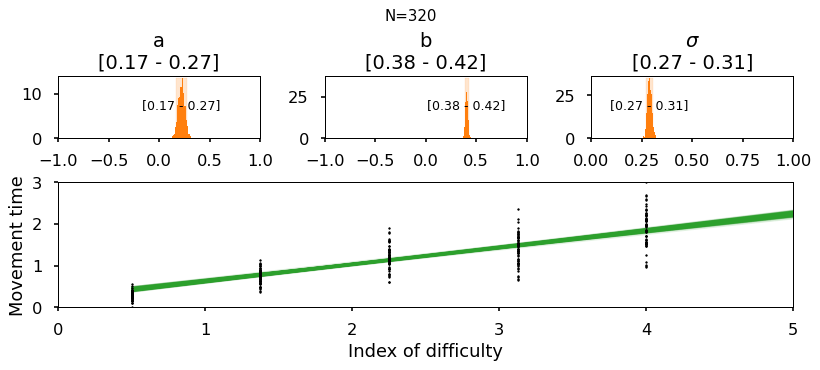

In [28]:
show_model(result_bad, mode='posterior')

#### What happens if we had less data?

There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.


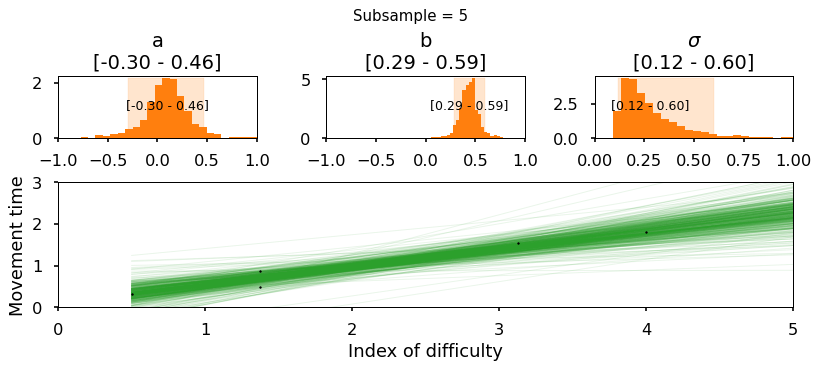

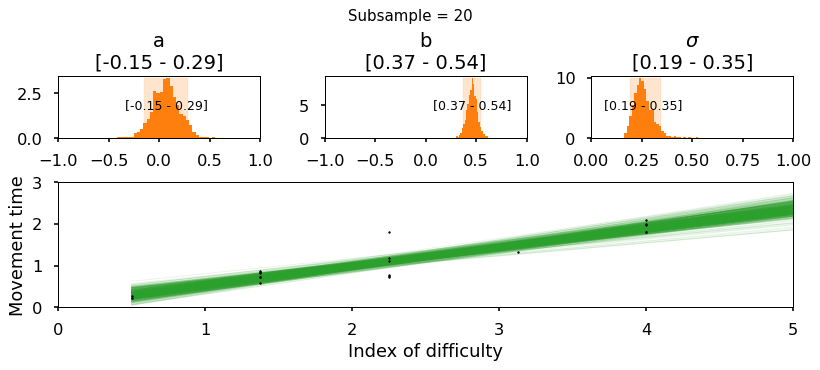

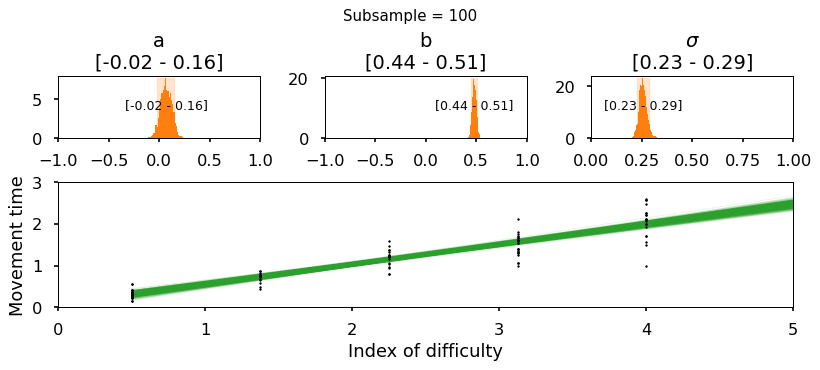

In [29]:
for sub in [5, 20, 100]:
    result_sub = sample_model(fitts_data["ID"], fitts_data["MT"], ns=sub);
    show_model(result_sub, mode='posterior')
    plt.suptitle(f"Subsample = {sub}")

#### Different prior, with small data

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


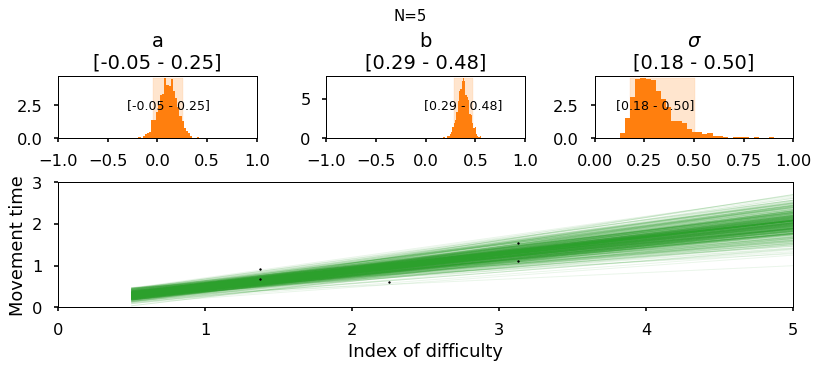

In [30]:
# a strong prior, but small sample size
result_strong_small = sample_model(fitts_data["ID"], fitts_data["MT"], a_prior=0.1, b_prior=0.1, a_mean_prior=0.1, b_mean_prior=0.4, std_prior=0.3, ns=5);
show_model(result_strong_small)

There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


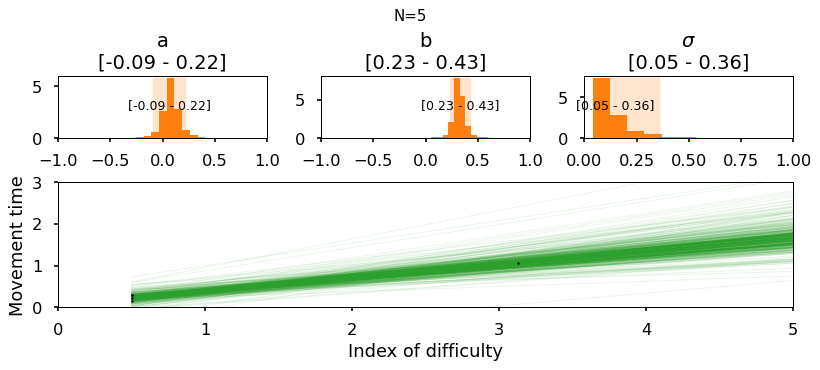

In [31]:
# a weak prior, but small sample size
result_weak_small = sample_model(fitts_data["ID"], fitts_data["MT"], a_prior=5, b_prior=5, std_prior=5, ns=5);
show_model(result_weak_small)

### A smaller dataset with a different device
Let's imagine we also get some data from a different device. Some changes:

* We have only three participants, and they only tried each target once
* The target widths and distances were chosen randomly, not systematically


In [32]:
fitts_alt = pd.read_csv("fitts_b.csv")
fitts_alt

,Unnamed: 0,ID,MT,participant,repetition,step
0,0,1.320732,0.896920,0,0,0
1,1,1.575152,0.999570,1,0,0
2,2,3.855876,2.191401,2,0,0
3,3,1.550392,0.944063,0,0,1
4,4,0.843315,0.406243,1,0,1
5,5,1.962600,1.184412,2,0,1
6,6,1.234662,0.866425,0,0,2
7,7,2.268632,0.543451,1,0,2
8,8,2.472520,1.334503,2,0,2
9,9,4.257248,2.708974,0,0,3


Text(0.5, 1.0, 'Fitts data (alternative device)')

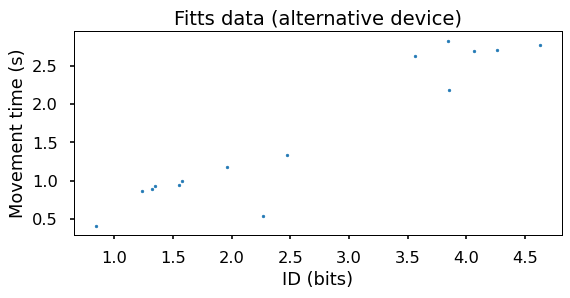

In [33]:
# plot the data
fitts_alt.plot.scatter('ID', 'MT', s=5)
plt.gca().set_xlabel("ID (bits)")
plt.gca().set_ylabel("Movement time (s)")
plt.title("Fitts data (alternative device)")

In [34]:
alt_result = sample_model(fitts_alt["ID"], fitts_alt["MT"]);

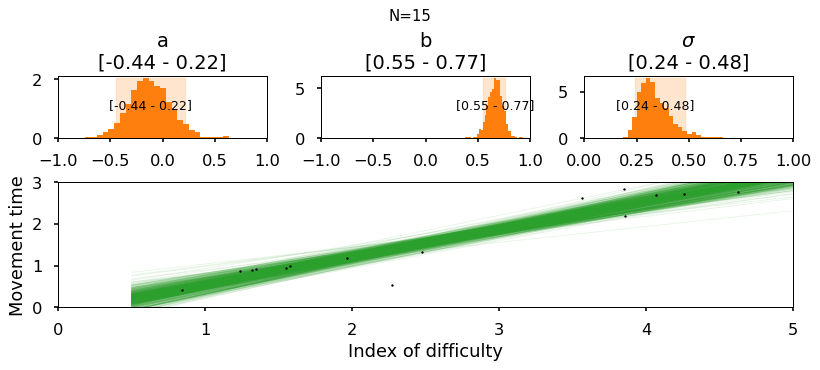

In [35]:
show_model(alt_result)

## Applying
How might we use or report these results? One thing we might want to do is to decide if the "alternate" device is superior or inferior to the original device.

### Does Fitts' law fit?
This question is answered by how well we can identify $a$ and $b$ from the data. We can see pretty clearly that the parameters are identified fairly precisely, and that the residual noise ($\sigma$) is small. There are other ways of quantifying this (especially if comparing multiple models), but a simple visual inspection is suitable here.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\local\anaconda3\envs\pymc3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

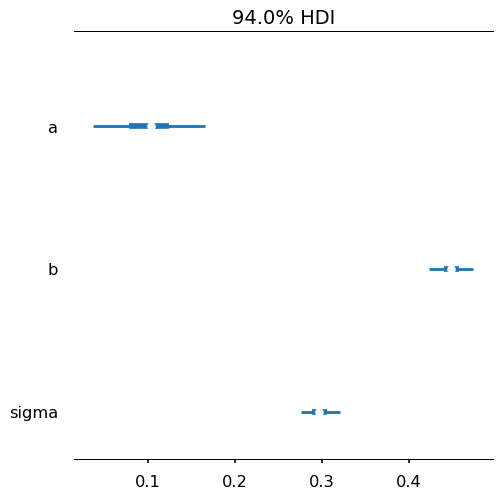

In [36]:
az.plot_forest(fitts_result["posterior"], combined=True)

Text(0, 0.5, 'MT')

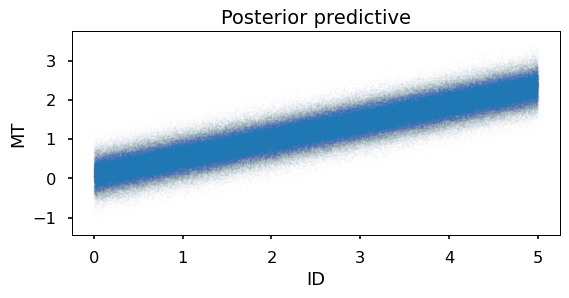

In [37]:
fig, ax = plt.subplots()
ax.scatter(fitts_result["posterior_predictive"]["ids"].ravel(), fitts_result["posterior_predictive"]["mt"].ravel(), s=1, alpha=0.01)
ax.set_title("Posterior predictive")
ax.set_xlabel("ID")
ax.set_ylabel("MT")

### Posterior comparisons
We have lots of ways we could look at this. If we think a smaller $b$ means better, we could compare distributions of $b$:

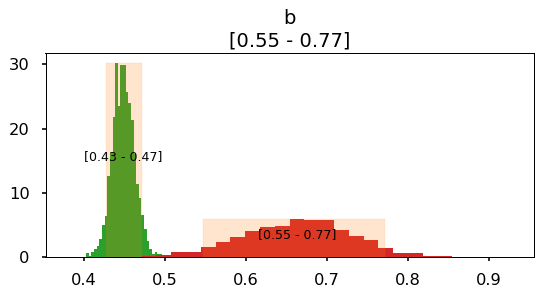

In [38]:
fig, ax = plt.subplots()
trace_hist(ax, fitts_result["posterior"]["b"], 'b', c='C2')
trace_hist(ax, alt_result["posterior"]["b"], 'b', c='C3')

In [39]:
differences = fitts_result["posterior"]["b"] - alt_result["posterior"]["b"]
print(np.mean(differences)) # average increase/decrease
print(np.mean(differences<0)) # probability of superiority

-0.21471102647527773
0.996


We can see there is very little overlap here; these have very different credible intervals. Or we could compare how noisy we think the experiments were:

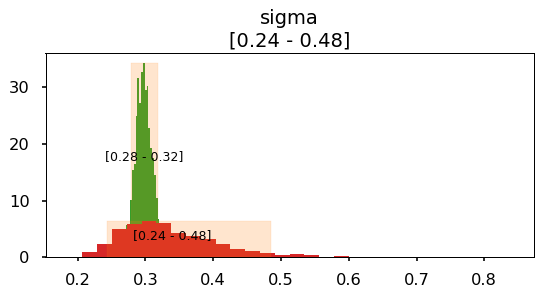

In [40]:
fig, ax = plt.subplots()
trace_hist(ax, fitts_result["posterior"]["sigma"], 'sigma', c='C2')
trace_hist(ax, alt_result["posterior"]["sigma"], 'sigma', c='C3')

### Using the generative model to make predictions
We can also make concrete predictions, since our model is generative. For example, what is the expected increase in time to select a target of ID=5?

0.8572711368439939


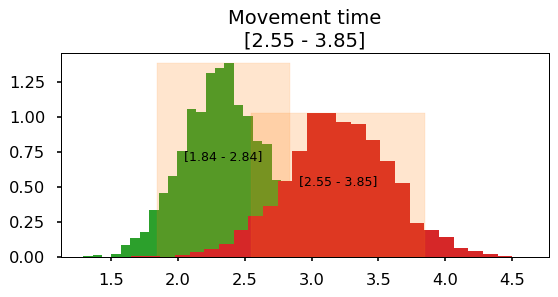

In [41]:
def model(a, b, std, id):
    return a + b * id + np.random.normal(0, 1, std.shape)*std

MT_std =  model(fitts_result["posterior"]["a"], fitts_result["posterior"]["b"], fitts_result["posterior"]["sigma"], id=5.0)
MT_alt =  model(alt_result["posterior"]["a"], alt_result["posterior"]["b"], alt_result["posterior"]["sigma"], id=5.0)

fig, ax = plt.subplots()
trace_hist(ax, MT_std, 'Movement time', c='C2')
trace_hist(ax, MT_alt, 'Movement time', c='C3')

print(np.mean(MT_alt - MT_std))

## Reflection

### What was gained?
* We can directly incorporate priors that make sense (e.g. informed by previous experiments).
* We get full distributions in our results, not summary statistics.
    * We can then choose the measure we want to use to report the results
* We don't have to worry about choosing the right test, or how to interpret p-values
    * in fact, we don't have to make dichotomous decisions at all
* We can answer questions we're actually interested in, like "how much longer will pointing at a 5 pixel target on the edge of the screen take with a console joystick"?
### What were the challenges?
* We had to be able to write our problem down in pymc3; this required a bit of finesse.
* Inference wasn't instant, even for this relatively simple problem. It just gets slower from here!
* Reporting the results requires choices -- it's not the case that we can just to a standardised process for every problem. 
* Setting priors required some thought; though as we saw, it often makes little difference to our inferences.
### What else could we have done
* Our model is very simple. We could easily have incorporated more details; perhaps further polynomial terms, like $MT = a + bID + cID^2$.
* More usefully, we could have made a more generative model -- one that predicts cursor *trajectories*, not just times, and fitted that to the data in exactly the same way.
* Or we could model different participants having personal a,b values, but where a,b values are drawn from a common population distribution:

In [42]:
# group by participants
participant_ids = np.array([data["ID"] for group, data in fitts_data.groupby("participant")])
participant_mts = np.array([data["MT"] for group, data in fitts_data.groupby("participant")])
n_participants = len(participant_ids)

In [43]:
# "partially pooled Bayesian hierarchical model"

with pymc3.Model() as model:
    # population a, b
    a_pop = pymc3.Normal("a_pop", 0.1, 1)
    b_pop = pymc3.Normal("b_pop", 0.5, 1)
    
    # common std. dev.
    a_std = pymc3.HalfNormal("a_std", 0.2)
    b_std = pymc3.HalfNormal("b_std", 0.2)
    # common noise
    std_prior = pymc3.HalfNormal("sigma", 1)        # HN(0,1)
    
    ids = pymc3.Uniform("ids", 0.0, 5.0, observed=participant_ids.T)        # U(0,5)
    # individual a,b
    a = pymc3.Normal("a", a_pop, a_std, shape=n_participants)
    b = pymc3.Normal("b", b_pop, b_std, shape=n_participants)
    lin = a + b * ids
    mt = pymc3.Normal("mt", mu=lin, sigma=std_prior, observed=participant_mts.T)
    grouped_result = pymc3_sample()
    


There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 681 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'Participant ID')

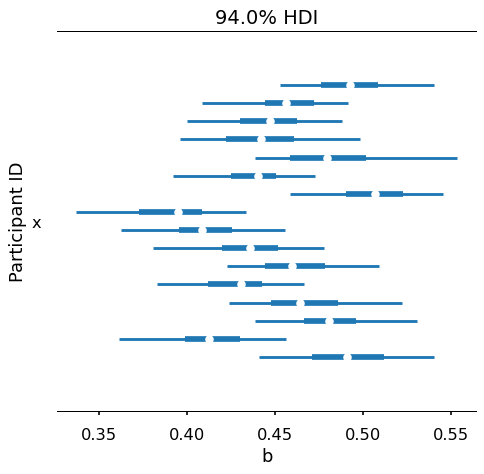

In [44]:
az.plot_forest(grouped_result["posterior"]["b"].T)
plt.xlabel("b")
plt.ylabel("Participant ID")

In [45]:
# az.from_pymc3(grouped_result["posterior"]).to_dataframe(filter_groups="like", groups="posterior").to_csv("fitts_pooled_model.csv")